# 1. Sample Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType
from datetime import datetime

## Create schema

In [2]:
feats = []
f = open('../features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

print(schema)

StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true),StructField(sensible_heat_net_flux_surface,FloatType,true),StructField(categorical_ice_pellets_yes1_no0_surface,FloatType,true),StructField(visibility_surface,FloatType,true),StructField(number_of_soil_layers_in_root_zone_surface,FloatType,true),StructField(categorical_freezing_rain_yes1_no0_surface,FloatType,true),StructField(pressure_reduced_to_msl_msl,FloatType,true),StructField(upward_short_wave_rad_flux_surface,FloatType,true),StructField(relative_humidity_zerodegc_isotherm,FloatType,true),StructField(categorical_snow_yes1_no0_surface,FloatType,true),StructField(u-component_of_wind_tropopause,FloatType,true),StructField(surface_wind_gust_surface,FloatType,true),StructField(total_cloud_cover_entire_atmosphere,FloatType,tru

## Load sample data

In [3]:
%%time

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:13030/nam_tiny.tdv')
df = df.select(['Timestamp', 'temperature_surface'])  # Select columns needed to speed up the process
df.show(3)

+-------------+-------------------+
|    Timestamp|temperature_surface|
+-------------+-------------------+
|1426377600000|          296.49802|
|1426377600000|          254.49802|
|1426377600000|          297.49802|
+-------------+-------------------+
only showing top 3 rows

CPU times: user 27.9 ms, sys: 4.15 ms, total: 32 ms
Wall time: 8.37 s


## Highest temperature

In [4]:
max_row = df.agg({'temperature_surface': 'max'}).collect()[0]
hotest = max_row['max(temperature_surface)']
hotest

306.4980163574219

In [5]:
# Creating a Degrees Kelvin to Degrees Celsius converter for later use.
def convert_dk_to_dc(dk):
    return dk - 273.15

In [6]:
dc = convert_dk_to_dc(hotest)
print(f'{hotest} Degrees Kelvin = {dc} Degrees Celsius')

306.4980163574219 Degrees Kelvin = 33.3480163574219 Degrees Celsius


## Hotest day

In [7]:
# Creating an SQL 'table'
df.createOrReplaceTempView("TINY_NAM")

# Getting the timestamp value of the highest temperature_surface row.
hotest_time = spark.sql(f'SELECT Timestamp FROM TINY_NAM WHERE temperature_surface = {hotest}').collect()
print(f'Hostest day count = {len(hotest_time)}')

unix_timestamp = hotest_time[0]['Timestamp'] / 1000
print(f'Unix Timestamp = {unix_timestamp}')

hotest_date = datetime.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
print(f'Hostest date = {hotest_date}')

Hostest day count = 1
Unix Timestamp = 1426377600.0
Hostest date = 2015-03-15 00:00:00


## Describe dataset

In [8]:
df.describe(['temperature_surface']).show()

+-------+-------------------+
|summary|temperature_surface|
+-------+-------------------+
|  count|                100|
|   mean|  284.9017663574219|
| stddev| 13.002025568205239|
|    min|          247.49802|
|    max|          306.49802|
+-------+-------------------+



In [9]:
_mean = 284.9017663574219
_mean_dc = convert_dk_to_dc(_mean)
print(f'Mean: {_mean} Degrees Kelvin = {_mean_dc} Degrees Celsius')

Mean: 284.9017663574219 Degrees Kelvin = 11.7517663574219 Degrees Celsius


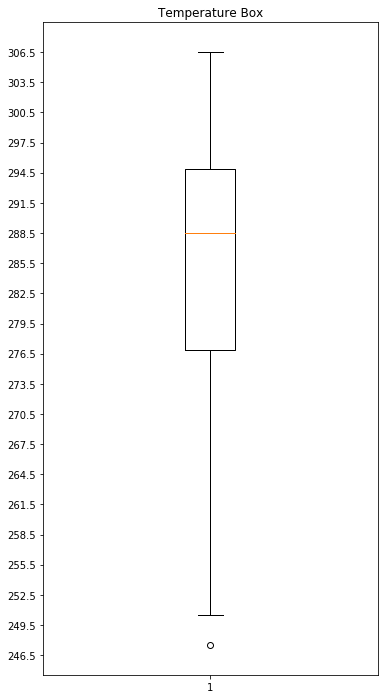

In [10]:
%matplotlib inline
pdf = df.toPandas()
plt.figure(figsize=(6, 12))
plt.boxplot(pdf['temperature_surface'].values)
plt.yticks(np.arange(min(pdf['temperature_surface'].values)-1, max(pdf['temperature_surface'].values)+1, 3))
plt.title("Temperature Box")
plt.show()

* We can observe that the highest temperature in the sample dataset is **306.5** Degrees Kelvin, which is 33.35 Degrees Celsius.
* That happened on **March 15th, 2015** (UTC).
* The result 306.5 is the max but not an outlier, so it's **not an anomaly** for the dataset.
* I removed three tailing zeros from the Unix Timestamp since it was in millisecond format and we need second format to convert it into datetime in Python.

# 2. Entire Dataset

In [11]:
%%time

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion11:13030/nam/*')
print(f'Loaded {df.count()} rows of data')
df.take(1)

Loaded 323759744 rows of data
CPU times: user 161 ms, sys: 55.5 ms, total: 217 ms
Wall time: 13min 39s


In [12]:
%%time

# Repeat the approach above
max_row = df.agg({'temperature_surface': 'max'}).collect()[0]
hotest = max_row['max(temperature_surface)']
print(f'Highest temperature = {hotest}')

dc = convert_dk_to_dc(hotest)
print(f'{hotest} Degrees Kelvin = {dc} Degrees Celsius')

df.createOrReplaceTempView("NAM")
hotest_time = spark.sql(f'SELECT Timestamp FROM NAM WHERE temperature_surface = {hotest}').collect()
print(f'Hostest day count = {len(hotest_time)}')

unix_timestamp = hotest_time[0]['Timestamp'] / 1000
print(f'Unix Timestamp = {unix_timestamp}')

hotest_date = datetime.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
print(f'Hostest date = {hotest_date}')

df.describe(['temperature_surface']).show()

Highest temperature = 331.390625
331.390625 Degrees Kelvin = 58.24062500000002 Degrees Celsius
Hostest day count = 1
Unix Timestamp = 1440266400.0
Hostest date = 2015-08-22 18:00:00
+-------+-------------------+
|summary|temperature_surface|
+-------+-------------------+
|  count|          323759744|
|   mean|  287.8572105962259|
| stddev| 13.716834080260098|
|    min|          218.99284|
|    max|          331.39062|
+-------+-------------------+

CPU times: user 205 ms, sys: 69 ms, total: 274 ms
Wall time: 17min 30s


In [13]:
_mean = 287.8572105962259
_mean_dc = convert_dk_to_dc(_mean)
print(f'Mean: {_mean} Degrees Kelvin = {_mean_dc} Degrees Celsius')

Mean: 287.8572105962259 Degrees Kelvin = 14.707210596225934 Degrees Celsius


In [14]:
%matplotlib inline
df = df.select(['temperature_surface'])  # Use as little memory as possible, OOM if using the entire dataset
pdf = df.toPandas()
plt.figure(figsize=(6, 12))
plt.boxplot(pdf['temperature_surface'].values)
plt.yticks(np.arange(min(pdf['temperature_surface'].values)-1, max(pdf['temperature_surface'].values)+1, 3))
plt.title("Temperature Box")
plt.show()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark-2.3.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark-2.3.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark-2.3.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43759)
Traceback (most recent call last):
  File "/usr/local/

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:43759)

* The highest temperature of the entire dataset is **331.4** Degrees Kelvin, which is 58.24 Degrees Celsius.
* The hotest date was **August 22, 2015** (UTC).
* This is **an anomaly** since the temperature was way off the normal range.